<a href="https://colab.research.google.com/github/toberoi05/Stanford-AIMI-Summer-Internship-Code/blob/main/XRay_Medical_Device_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mdai --quiet
!pip install pydicom==1.4.2 --force-reinstall --quiet

import mdai
from mdai.utils.common_utils import json_to_dataframe
from mdai.visualize import draw_box_on_image, display_annotations
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive')

     |████████████████████████████████| 266 kB 8.4 MB/s 
     |████████████████████████████████| 2.0 MB 53.1 MB/s 
     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 12.8 MB 23.5 MB/s 
     |████████████████████████████████| 35.3 MB 214 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dicom2nifti 2.4.2 requires pydicom>=2.2.0, but you have pydicom 1.4.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
p.show_label_groups()

Label Group, Id: G_WK10kY, Name: Default group
	Labels:
	Id: L_R6vr06, Name: Erroneous

Label Group, Id: G_8On3MY, Name: Devices (Main)
	Labels:
	Id: L_5N0vP4, Name: Endotracheal Tube
	Id: L_y4mnA1, Name: Central venous catheter
	Id: L_A1yz9N, Name: Chest Tube

Label Group, Id: G_VK3BlY, Name: Devices (Secondary)
	Labels:
	Id: L_ZNAO94, Name: Pacemaker/ICD



In [ ]:
labels_dict = {
    'L_5N0vP4': 1, # Endotracheal Tube
    'L_y4mnA1': 2, # Central venous catheter
    'L_A1yz9N': 3, # Chest Tube
}
p.set_labels_dict(labels_dict)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
import torch.nn as nn

imgIds = dataset.all_image_ids


In [ ]:
from sklearn.model_selection import train_test_split as tts 

train_ids, test_ids = tts(imgIds, test_size=300, random_state = 42)

preloadedImagesTrain = []
for id in train_ids:
  preloadedImagesTrain.append(mdai.visualize.load_dicom_image(id, to_RGB=True, rescale=True))

preloadedImagesTest = []
for id in test_ids:
  preloadedImagesTest.append(mdai.visualize.load_dicom_image(id, to_RGB=True, rescale=True))

First, I am Predicting the Type of Instrument (1,2,3) Classification


In [ ]:
#1 = ET, 2 = CVC, 3 = CT
#mdai.visualize.load_dicom_image(image_id, to_RGB=False, rescale=True)
#mdai.visualize.get_image_ground_truth(image_id=image_id, dataset=dataset)
#minX = 320, minY = 320, maxX = 337, maxY = 400; x = width, y = height
#problem: varying image dimensions, varying label sizes (depends on # of annotations)
classes = [1,2,3]

ids = imgIds
# ctr = 0
# for id in ids:
#   try:
#     temp = dataset.get_annotations_by_image_id(id)
#     tempList = []
#     for dictionary in temp:
#       tempList.append(dictionary["labelId"])
#     if len(set(tempList)) != len(tempList):
#       ctr+=1
#       print(ids.index(id), len(tempList), len(set(tempList)))
#   except:
#     pass
# print(ctr)

# maxX = 100
# maxY = 100
# for id in imgIds:
#   maxX = max(maxX,mdai.visualize.load_dicom_image(id, to_RGB=False, rescale=True).shape[0])
#   maxY = max(maxY,mdai.visualize.load_dicom_image(id, to_RGB=False, rescale=True).shape[1])
# print(maxX,maxY)

#binary classification for checking instrument type

#use labels_dict

#use data key in order to get coords of bounding box
mean = torch.tensor([0,0,0])
std = torch.tensor([0,0,0])
for img in preloadedImagesTrain:
  img = torch.tensor(img, dtype = torch.float32)
  temp = img.mean([0,1])
  mean = mean + img.mean([0,1])
  std = std + img.std([0,1])

for img in preloadedImagesTest:
  img = torch.tensor(img, dtype = torch.float32)
  temp = img.mean([0,1])
  mean = mean + img.mean([0,1])
  std = std + img.std([0,1])

mean = mean/(255 *len(ids))
std = std/(255 *len(ids))

print(mean, std)

# import torch_xla
# import torch_xla.core.xla_model as xm

class DicomDataset(Dataset):
  def __init__(self, ids, preloadedImages, dataset, labels_dict, boundingBox = False, transform = None, outputTransform = None):
      super().__init__()
      self.ids = ids
      self.preloadedImages = preloadedImages
      self.boundingBox = boundingBox
      self.transform = transform
      self.outputTransform = outputTransform
      self.dataset=dataset
      self.labels_dict = labels_dict
  
  def __getitem__(self, idx):
    imgID = self.ids[idx]
    self.x = self.preloadedImages[idx]
    try:
      self.annotations = self.dataset.get_annotations_by_image_id(imgID)
    except:
      self.annotations = []
    labels = []

    #bounding box output should be 4x3 instead of 1x3, assume no duplicates for now
    #Is it feasible if I treat the bounding boxes like this. In the testing, if the predicted column is 1, then the bounding box testing should return a nonzero value, else, it should also return [0,0,0,0]
    for dictionary in self.annotations:
      labels.append(dictionary["labelId"])

    indicies = []
    for label in labels:
      indicies.append(self.labels_dict[label])
    
    self.output = []
    for i in range(1,4):
      if(i in indicies):
        self.output.append(1)
      else:
        self.output.append(0)

    if(self.transform):
      self.x = self.transform(self.x)
      # mean = self.x.mean([1,2])
      # std = self.x.std([1,2])
      # normalize = transforms.Normalize(mean,std)

      # self.x = normalize(self.x)

    if(self.outputTransform):
      self.output = self.outputTransform(self.output)

    return self.x, torch.FloatTensor(self.output)

    
  def __repr__(self):
      return "This is my dataset and it has length {}".format(len(self))

  def __len__(self):
    return len(self.ids)


#transforms.Compose()
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((320,320)), transforms.Normalize(mean = mean, std = std), transforms.RandomInvert(1.)])

train_dataset = DicomDataset(train_ids, preloadedImagesTrain, dataset, labels_dict,boundingBox = False, transform = transform)
test_dataset = DicomDataset(test_ids, preloadedImagesTest, dataset, labels_dict,boundingBox = False, transform = transform)

# train_datasetBounding = DicomDataset(train_ids, preloadedImages, dataset, labels_dict, boundingBox = True, transform = transform)
# test_datasetBounding = DicomDataset(test_ids, preloadedImages, dataset, labels_dict, boundingBox = True, transform = transform)

my_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 2)
my_dataloader2 = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = 2)

print(train_dataset.__getitem__(9))
print(test_dataset.__getitem__(9))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tensor([0.4935, 0.4935, 0.4935]) tensor([0.2904, 0.2904, 0.2904])
(tensor([[[-0.4063, -0.4333, -0.4603,  ..., -0.5143, -0.5278, -0.5278],
         [-0.4198, -0.4468, -0.4603,  ..., -0.5548, -0.5548, -0.5683],
         [-0.4198, -0.4468, -0.4738,  ..., -0.5953, -0.6088, -0.6223],
         ...,
         [-0.3388, -0.4063, -0.4468,  ..., -0.5683, -0.5818, -0.6088],
         [-0.3388, -0.4063, -0.4468,  ..., -0.5278, -0.5413, -0.5548],
         [-0.3253, -0.3928, -0.4468,  ..., -0.4873, -0.4873, -0.5008]],

        [[-0.4063, -0.4333, -0.4603,  ..., -0.5143, -0.5278, -0.5278],
         [-0.4198, -0.4468, -0.4603,  ..., -0.5548, -0.5548, -0.5683],
         [-0.4198, -0.4468, -0.4738,  ..., -0.5953, -0.6088, -0.6223],
         ...,
         [-0.3388, -0.4063, -0.4468,  ..., -0.5683, -0.5818, -0.6088],
         [-0.3388, -0.4063, -0.4468,  ..., -0.5278, -0.5413, -0.5548],
         [-0.3253, -0.3928, -0.4468,  ..., -0.4873, -0.4873, -0.5008]],

        [[-0.4063, -0.4333, -0.4603,  ..., -0.514

In [ ]:
class PreprocessAnnotations(object):
  def __init__(self, dataset, size, to_single_bbox=True):
    self.dataset = dataset
    self.size = size
    self.to_single_bbox = to_single_bbox

  def __call__(self, annotations, image):
    # retrieve the image labels and resized bounding boxes
    targets = torch.zeros(3).long() # 3 entries (one for each device type)
    bboxes = []
    
    for ann in annotations:
      if 'data' in ann and 'labelId' in ann:
        # classification labels
        class_idx = self.dataset.label_id_to_class_id(ann['labelId']) - 1 # 0-based class index
        targets[class_idx] = 1

        # bounding boxes
        height, width, _ = image.shape
        div_y, div_x = height / self.size, width / self.size
        y, x = ann['data']['y'] / div_y, ann['data']['x'] / div_x
        new_height, new_width = ann['data']['height'] / div_y, ann['data']['width'] / div_x
        bbox = torch.tensor([y, x, new_height, new_width, class_idx + 1])
        bboxes.append(bbox)

    # create a single bbox to facilitate an easy (but incorrect) single bbox detector model
    if self.to_single_bbox:
      bboxes = bboxes[0] if len(bboxes) > 0 else torch.tensor([0., 0., 0., 0., 0.])

    return targets, bboxes

In [ ]:
class ExtendedResNet(nn.Module):
  def __init__(self, pretrained):
    super(ExtendedResNet, self).__init__() # inherit nn.Module
    self.pretrained = pretrained # import pretrained model
    pretrained.fc = nn.Linear(pretrained.fc.in_features, 30)
    self.dropout = nn.Dropout(p=0.5)
    self.final = nn.Linear(30,3)
  def forward(self, x):
    x = self.pretrained(x)
    x = torch.relu(x)
    x = self.dropout(x)
    x = self.final(x)
    return x

In [ ]:
#testing data
def checkAccuracy(train = False):
  if(not train):
    dataloader = my_dataloader2 

  else:
    dataloader = my_dataloader
  with torch.no_grad():
    model.eval()
    totalSamples = 0
    totalCorrect = 0
    for index, (image, labels) in enumerate(dataloader):
      image = image.to(device)
      labels = labels.to(device)
      raw = torch.sigmoid(model(image))
      pred = torch.round(raw)
      totalSamples+=(labels.shape[0] * 3)
      for index, data in enumerate(pred):
        for i in range(3):
          if(torch.equal(pred[index][i], labels[index][i])):
            #print(pred[index], labels[index], i)
            totalCorrect += 1
          else:
            pass
            #print(raw[index], labels[index])
    print(totalCorrect*100/totalSamples)
    return totalCorrect*100/totalSamples

In [ ]:
import torchvision
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import lr_scheduler
from keras import models
from keras import layers 
import seaborn as sns
import matplotlib.pyplot as plt

tempModel = torchvision.models.resnet18(pretrained=True)

model = ExtendedResNet(tempModel)

model.to(device)


learning_rate= 0.0001
numIters = 8

loss = nn.BCEWithLogitsLoss(weight = torch.tensor([1,1,1], device = device))
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = 0.1)
stepScheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [3,10], gamma = 0.1)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for epoch in range(numIters):
  currentLoss = 0.0
  validationLoss = 0.0
  model.train()
  for index, (images, labels) in enumerate(my_dataloader):

    images = images.to(device)
    labels = labels.to(device)
    predictedOutputs = model(images)

    error = loss(predictedOutputs, labels.float())
    error.backward()
    optimizer.step()
    optimizer.zero_grad()
    currentLoss+=error.item()

  print(f'[{epoch + 1}] loss: {currentLoss / len(my_dataloader):.3f}')
  train_loss.append(currentLoss / len(my_dataloader))
  train_acc.append(checkAccuracy(train = True))
  currentLoss = 0.0

  stepScheduler.step()

  #validation
  model.eval()
  with torch.no_grad():
    for index, (image, labels) in enumerate(my_dataloader2):
      image = image.to(device)
      labels = labels.to(device)
      outputs = model(image)
      error = loss(outputs, labels.float())
      validationLoss += error.item()

    print(f'[{epoch + 1}] val_loss: {validationLoss / len(my_dataloader2):.3f}')
    val_loss.append(validationLoss / len(my_dataloader2))
    val_acc.append(checkAccuracy())
    validationLoss = 0.0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[1] loss: 0.492
85.5925925925926
[1] val_loss: 0.382
85.55555555555556
[2] loss: 0.382
87.81481481481481
[2] val_loss: 0.359
85.77777777777777
[3] loss: 0.303
88.75925925925925
[3] val_loss: 0.444
85.88888888888889
[4] loss: 0.227
96.25925925925925
[4] val_loss: 0.363
85.66666666666667
[5] loss: 0.205
96.48148148148148
[5] val_loss: 0.364
85.88888888888889
[6] loss: 0.185
97.20370370370371
[6] val_loss: 0.364
86.0
[7] loss: 0.174
97.5925925925926
[7] val_loss: 0.369
85.11111111111111
[8] loss: 0.166
97.88888888888889
[8] val_loss: 0.374
85.44444444444444


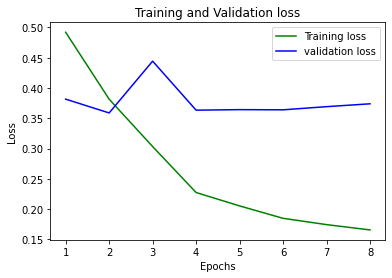

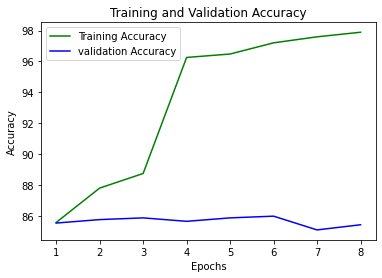

In [ ]:
#Plot Graph

epochs = range(1,numIters + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
checkAccuracy()

85.44444444444444


85.44444444444444

In [ ]:
IMAGE_SIZE=320 # only if you resized your images this way (torchvision.transforms.Resize(IMAGE_SIZE,IMAGE_SIZE)), otherwise you need to adapt this
preloadedImages = []
for id in test_dataset.all_image_ids:
  preloadedImages.append(mdai.visualize.load_dicom_image(id, to_RGB=True, rescale=True))

for img in preloadedImages:
  img = torch.tensor(img, dtype = torch.float32)
  temp = img.mean([0,1])
  mean = mean + img.mean([0,1])
  std = std + img.std([0,1])

mean = mean/(255 *len(test_dataset.all_image_ids))
std = std/(255 *len(test_dataset.all_image_ids))

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((320,320)), transforms.Normalize(mean = mean, std = std), transforms.RandomInvert(1.)])

officialTestDataset = DicomDataset(test_dataset.all_image_ids, preloadedImages, test_dataset, labels_dict, boundingBox = False, transform = transform)

In [ ]:
dl = torch.utils.data.DataLoader(officialTestDataset, batch_size=16)
batch = next(iter(dl))
print(batch)

[tensor([[[[-0.5188, -0.4934, -0.4853,  ..., -0.4721, -0.4721, -0.4721],
          [-0.5124, -0.4934, -0.4853,  ..., -0.4721, -0.4721, -0.4721],
          [-0.5056, -0.4828, -0.4721,  ..., -0.4721, -0.4721, -0.4721],
          ...,
          [-0.3637, -0.3444, -0.3423,  ..., -0.0028, -0.0520, -0.0768],
          [-0.3674, -0.3543, -0.3539,  ..., -0.0174, -0.0509, -0.0944],
          [-0.3738, -0.3617, -0.3575,  ...,  0.0220, -0.0087, -0.0572]],

         [[-0.5188, -0.4934, -0.4853,  ..., -0.4721, -0.4721, -0.4721],
          [-0.5124, -0.4934, -0.4853,  ..., -0.4721, -0.4721, -0.4721],
          [-0.5056, -0.4828, -0.4721,  ..., -0.4721, -0.4721, -0.4721],
          ...,
          [-0.3637, -0.3444, -0.3423,  ..., -0.0028, -0.0520, -0.0768],
          [-0.3674, -0.3543, -0.3539,  ..., -0.0174, -0.0509, -0.0944],
          [-0.3738, -0.3617, -0.3575,  ...,  0.0220, -0.0087, -0.0572]],

         [[-0.5188, -0.4934, -0.4853,  ..., -0.4721, -0.4721, -0.4721],
          [-0.5124, -0.4934, 

In [ ]:
#Testing

with torch.no_grad():
  model.eval()
  totalSamples = 0
  totalCorrect = 0
  for index, (image, labels) in enumerate(dl):
    image = image.to(device)
    labels = labels.to(device)
    raw = torch.sigmoid(model(image))
    pred = torch.round(raw)
    totalSamples+=(labels.shape[0] * 3)
    for index, data in enumerate(pred):
      for i in range(3):
        if(torch.equal(pred[index][i], labels[index][i])):
          #print(pred[index], labels[index], i)
          totalCorrect += 1
        else:
          pass
          #print(raw[index], labels[index])
  print(totalCorrect*100/totalSamples)

81.83333333333333


In [ ]:
#Regression Model to predict location of bounding box
#To test accuracy, potentially calculate overlapping area



In [ ]:
#calculating classification metrics
from sklearn.metrics import classification_report
predictions = [[],[],[]]
actual = [[],[],[]]
with torch.no_grad():
  totalSamples = 0
  correct = [0, 0, 0]
  model.eval()
  tP = [0, 0, 0] # true positive means that predicted 1 when actually 1
  tN = [0, 0, 0]
  fP = [0, 0, 0]
  fN = [0, 0, 0]
  for index, (image, labels) in enumerate(dl):
    image = image.to(device)
    labels = labels.to(device)
    pred = torch.round(torch.sigmoid(model(image)))
    totalSamples+=labels.shape[0]
    for index, data in enumerate(pred):
      for i in range(3):
        predictions[i].append(pred[index][i].item())
        actual[i].append(labels[index][i].item())
        if(torch.equal(pred[index][i], labels[index][i])):
          if(pred[index][i]==1):
            tP[i]+=1
          else:
            tN[i]+=1
        else:
          if(pred[index][i]==1):
            fP[i]+=1
          else:
            fN[i]+=1

  print("%... ")

target_names = ["Is Not Present", "Is Present"]

print("Endotracheal Tube Metrics")
print(classification_report(actual[0], predictions[0], target_names=target_names))
print()
print("Central Venous Catheter Metrics")
print(classification_report(actual[1], predictions[1], target_names=target_names))
print()
print("Chest Tube Metrics ")
print(classification_report(actual[2], predictions[2], target_names=target_names))
  # print()

  # for i in range(3):
  #   print(i)

  #   print("correct:")
  #   correct[i] = (tN[i]+tP[i])*100/(tN[i]+tP[i]+fN[i]+fP[i])
  #   print(correct[i])
  #   print("sensitivity: ")
  #   print(tP[i]*100/(tP[i]+fN[i]))
  #   print("specificity: ")
  #   print(tN[i]*100/(tN[i]+fP[i]))

  #   print()

  #   #uncomment below if you want to know true positive rate, etc.

  #   print("tP[i]")
  #   print(tP[i]*100/totalSamples)
  #   print("tN[i]")
  #   print(tN[i]*100/totalSamples)
  #   print("fP[i]")
  #   print(fP[i]*100/totalSamples)
  #   print("fN[i]")
  #   print(fN[i]*100/totalSamples)
    
  #   print()

print("total correct:")
print((correct[0]+correct[1]+correct[2])/3)

%... 
Endotracheal Tube Metrics
                precision    recall  f1-score   support

Is Not Present       0.78      0.99      0.88       154
    Is Present       0.80      0.09      0.16        46

      accuracy                           0.79       200
     macro avg       0.79      0.54      0.52       200
  weighted avg       0.79      0.79      0.71       200


Central Venous Catheter Metrics
                precision    recall  f1-score   support

Is Not Present       0.75      0.99      0.85       147
    Is Present       0.67      0.08      0.14        53

      accuracy                           0.74       200
     macro avg       0.71      0.53      0.49       200
  weighted avg       0.73      0.74      0.66       200


Chest Tube Metrics 
                precision    recall  f1-score   support

Is Not Present       0.93      1.00      0.96       185
    Is Present       0.00      0.00      0.00        15

      accuracy                           0.93       200
     macro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_accuracy = 0
total_ba = 0

for i in range(3):
    print(i)

    print()

    print("sensitivity/TPR: ")
    tpr = tP[i]*100/(tP[i]+fN[i])
    print(tpr)
    print("specificity/TNR: ")
    tnr = tN[i]*100/(tN[i]+fP[i])
    print(tnr)

    print()

    print("accuracy:")
    accuracy = (tN[i]+tP[i])*100/(totalSamples)
    total_accuracy += accuracy
    print(accuracy)
    print("balanced accuracy:")
    ba = (tnr+tpr)/2
    total_ba += ba
    print(ba)

    print()

    # uncomment below if you want to know positive predictive value and npv

    print("ppv/precision:")
    if(i == 2):
      ppv = 0
    else:
      ppv = tP[i]*100/(tP[i]+fP[i])
    print(ppv)
    print("npv:")
    npv = tN[i]*100/(tN[i]+fN[i])
    print(npv)
    #
    print()

    # uncomment below if you want to know f1-score
    print("f1-score")

    if(i == 2):
      print("NA")
    else:
      print(2*ppv*tpr/(ppv+tpr))

    #print(2*ppv*tpr/(ppv+tpr))
    #
    print()
    print()

print("average accuracy:")
print(total_accuracy/3)
print("average balanced accuracy:")
print(total_ba/3)

0

sensitivity/TPR: 
8.695652173913043
specificity/TNR: 
99.35064935064935

accuracy:
78.5
balanced accuracy:
54.0231507622812

ppv/precision:
80.0
npv:
78.46153846153847

f1-score
15.686274509803921


1

sensitivity/TPR: 
7.547169811320755
specificity/TNR: 
98.63945578231292

accuracy:
74.5
balanced accuracy:
53.09331279681684

ppv/precision:
66.66666666666667
npv:
74.74226804123711

f1-score
13.559322033898304


2

sensitivity/TPR: 
0.0
specificity/TNR: 
100.0

accuracy:
92.5
balanced accuracy:
50.0

ppv/precision:
0
npv:
92.5

f1-score
NA


average accuracy:
81.83333333333333
average balanced accuracy:
52.37215451969934


In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrixET = confusion_matrix(actual[0] , predictions[0])
cf_matrixCVC = confusion_matrix(actual[1] , predictions[1])
cf_matrixCH = confusion_matrix(actual[2] , predictions[2])

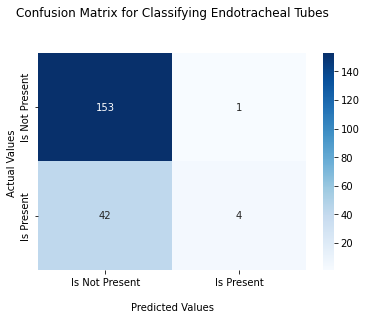

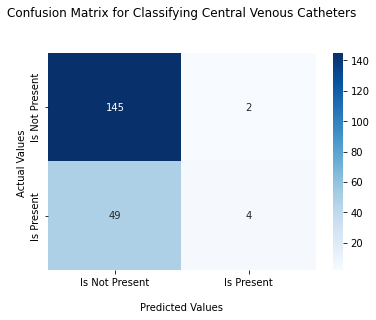

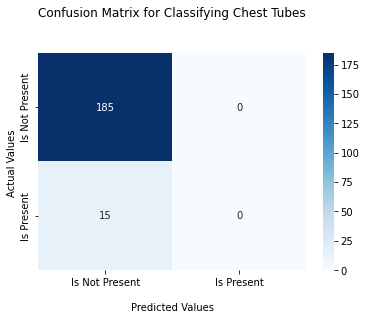

In [ ]:
#show confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrixET, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for Classifying Endotracheal Tubes\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Is Not Present','Is Present'])
ax.yaxis.set_ticklabels(['Is Not Present','Is Present'])

## Display the visualization of the Confusion Matrix.
plt.show()

ax = sns.heatmap(cf_matrixCVC, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for Classifying Central Venous Catheters\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Is Not Present','Is Present'])
ax.yaxis.set_ticklabels(['Is Not Present','Is Present'])

plt.show()

ax = sns.heatmap(cf_matrixCH, annot=True, cmap='Blues', fmt = 'g')

ax.set_title('Confusion Matrix for Classifying Chest Tubes\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Is Not Present','Is Present'])
ax.yaxis.set_ticklabels(['Is Not Present','Is Present'])

plt.show()

ET ROC Value: 0.5563636363636364
CVC ROC Value: 0.5639404788543297
Chest Tube ROC Value: 0.5


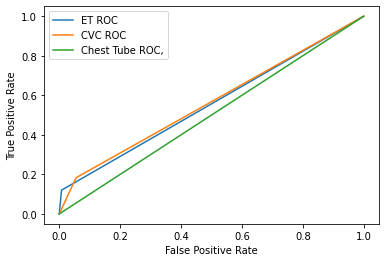

In [ ]:
#ROC Curve

from sklearn import metrics

plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(actual[0],  predictions[0])
plt.plot(fpr,tpr, label = "ET ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()

auc = metrics.roc_auc_score(actual[0], predictions[0])
print("ET ROC Value:", auc)

fpr, tpr, _ = metrics.roc_curve(actual[1],  predictions[1])
plt.plot(fpr,tpr, label = "CVC ROC")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

auc = metrics.roc_auc_score(actual[1], predictions[1])
print("CVC ROC Value:", auc)

fpr, tpr, _ = metrics.roc_curve(actual[2],  predictions[2])
plt.plot(fpr,tpr, label = "Chest Tube ROC,")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
plt.legend(loc=0)

auc = metrics.roc_auc_score(actual[2], predictions[2])
print("Chest Tube ROC Value:", auc)
